## Xác thực chữ ký bằng Transfer Learning kết hợp với Fine-tuning

Import thư viện

In [2]:

import os
import glob
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical


Thiết lập 

In [3]:

# Đường dẫn gốc
root_dir = "./Dataset"
SIZE = 224


Tải dữ liệu và dán nhãn

In [4]:

# Tải dữ liệu và gán nhãn
data = []
labels = []
data_names = []

for dataset_folder in os.listdir(root_dir):
    dataset_path = os.path.join(root_dir, dataset_folder)
    for label_folder in ['real', 'forge']:
        label_path = os.path.join(dataset_path, label_folder)
        label = 0 if label_folder == 'real' else 1
        for img_path in glob.glob(os.path.join(label_path, '*.*')):
            data_names.append(img_path)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (SIZE, SIZE))
            data.append(img)
            labels.append(label)

data = np.array(data) / 255.0
labels = to_categorical(np.array(labels))


Chia train/test

In [5]:

# Chia train/test
train_data, test_data, train_labels, test_labels, train_data_names, test_data_names = train_test_split(
    data, labels, data_names, test_size=0.2, stratify=labels, random_state=42
)


Lưu tên ảnh (có thể có hoặc không)

In [6]:

# Lưu tên ảnh
with open('./train_data_names.pkl', 'wb') as fp:
    pickle.dump(train_data_names, fp)
with open('./test_data_names.pkl', 'wb') as fp:
    pickle.dump(test_data_names, fp)


Khởi tạo mô hình


In [7]:

# Khởi tạo mô hình
# input_ = (SIZE, SIZE, 3)
EPOCHS = 20
BS = 64
output_ = 2


Sử dụng mô hình VGG16 đã được huấn luyện sẵn trên tập dữ liệu ImageNet để giải quyết một bài toán phân loại 2 lớp (softmax đầu ra có 2 node).

In [11]:

from tensorflow.keras import Input
from tensorflow.keras.metrics import Precision, Recall

input_ = Input(shape=(224, 224, 3))
base_model = applications.VGG16(weights='imagenet', include_top=False, input_tensor=input_)
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output_ = Dense(2, activation='softmax')(x)

model = Model(inputs=input_, outputs=output_)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy', Precision(), Recall()])


Huấn luyện mô hình

In [12]:
# Huấn luyện
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
progess = model.fit(train_data, train_labels,
                    batch_size=BS,
                    epochs=EPOCHS,
                    validation_split=0.3,
                    callbacks=[earlyStopping])



Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 211s 29s/step - accuracy: 0.5861 - loss: 0.8616 - precision: 0.5861 - recall: 0.5861 - val_accuracy: 0.5055 - val_loss: 0.6834 - val_precision: 0.5055 - val_recall: 0.5055
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 305s 37s/step - accuracy: 0.6202 - loss: 0.6437 - precision: 0.6202 - recall: 0.6202 - val_accuracy: 0.6264 - val_loss: 0.6670 - val_precision: 0.6264 - val_recall: 0.6264
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 284s 41s/step - accuracy: 0.7614 - loss: 0.5411 - precision: 0.7614 - recall: 0.7614 - val_accuracy: 0.5549 - val_loss: 0.6439 - val_precision: 0.5549 - val_recall: 0.5549
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 276s 40s/step - accuracy: 0.7993 - loss: 0.4175 - precision: 0.7993 - recall: 0.7993 - val_accuracy: 0.7967 - val_loss: 0.4505 - val_precision: 0.7967 - val_recall: 0.7967
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 238s 34s/step - accuracy: 0.9451 - loss: 0.2000 - precision: 0.9451 - recall: 0.9451 - val_accuracy: 0.8407 - val_loss: 0.3884 - val

Vẽ các biểu đồ 

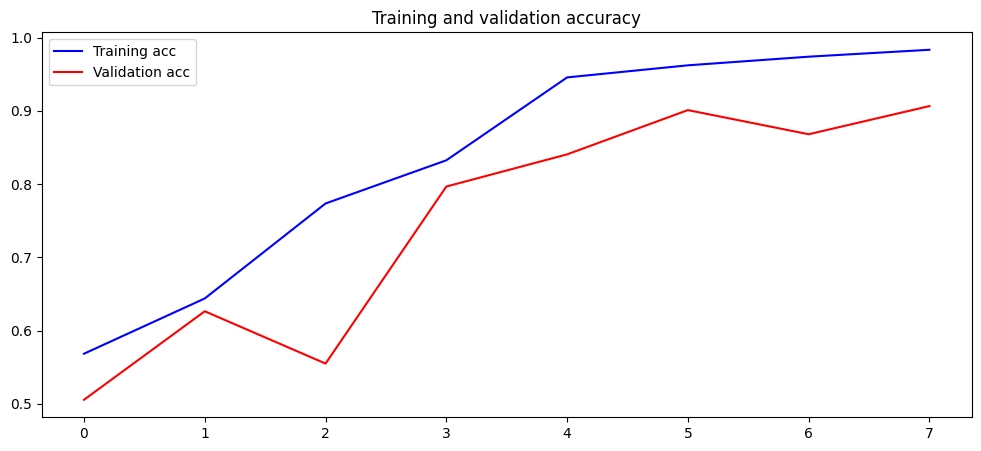

<Figure size 640x480 with 0 Axes>

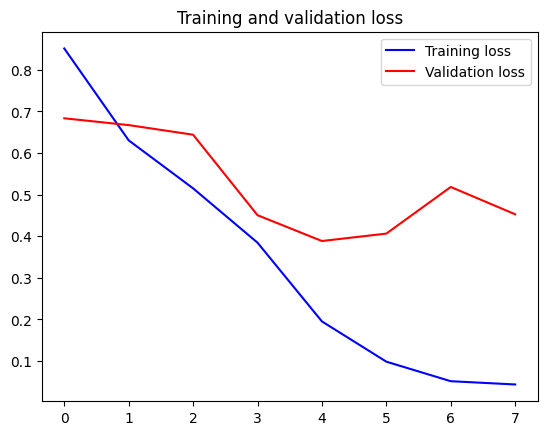

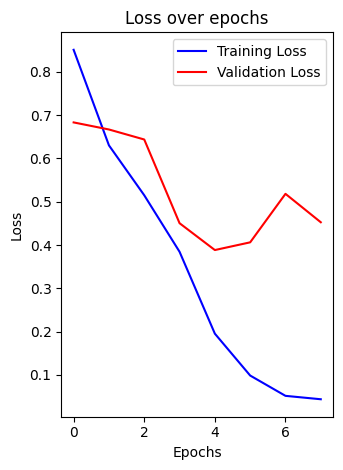

In [13]:
# Vẽ biểu đồ
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(12, 5))

 # Accuracy
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



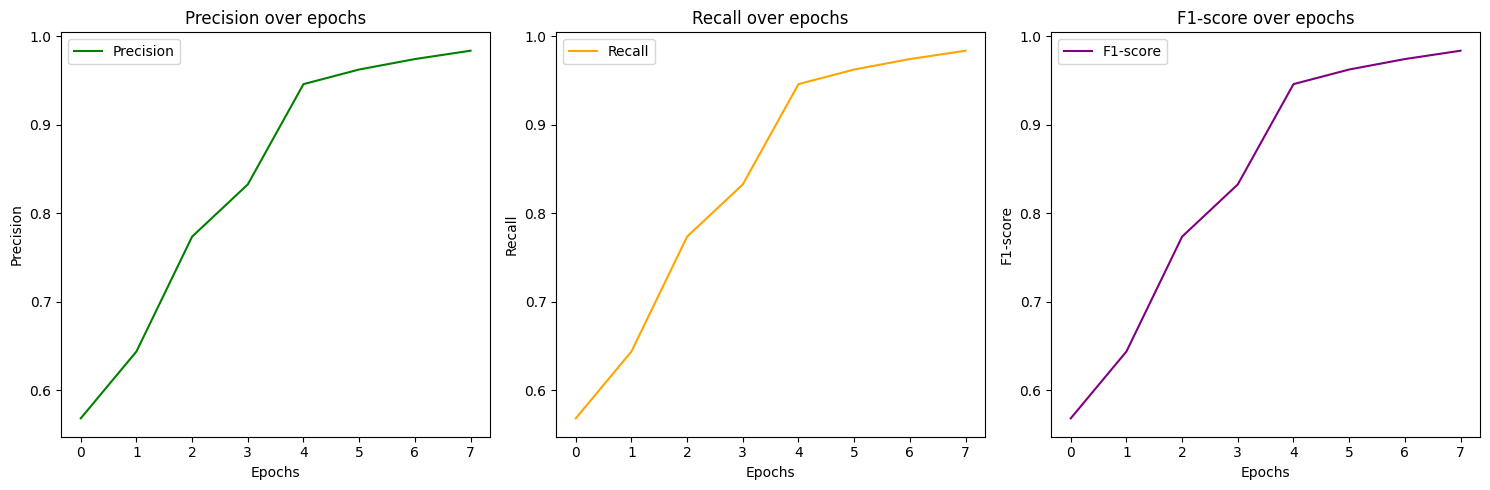

In [17]:
precision = progess.history['precision']
recall = progess.history['recall']
f1_score = [2 * (p * r) / (p + r + 1e-7) for p, r in zip(precision, recall)]
epochs = range(len(precision))

plt.figure(figsize=(15, 5))

# Precision
plt.subplot(1, 3, 1)
plt.plot(epochs, precision, 'g', label='Precision')
plt.title('Precision over epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(1, 3, 2)
plt.plot(epochs, recall, 'orange', label='Recall')
plt.title('Recall over epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# F1-score
plt.subplot(1, 3, 3)
plt.plot(epochs, f1_score, 'purple', label='F1-score')
plt.title('F1-score over epochs')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.legend()

plt.tight_layout()
plt.show()


Lấy trích xuất đặc trưng 

In [16]:

# Trích đặc trưng
intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)
intermediate_output_train = intermediate_layer_model.predict(train_data)
intermediate_output_test = intermediate_layer_model.predict(test_data)
np.save('./VGG16_Adam_train', intermediate_output_train)
np.save('./VGG16_Adam_test', intermediate_output_test)

# Dự đoán & lưu model
test_output = model.predict(test_data)     
x = np.argmax(test_output, axis=1)

model.save('./model.h5', save_format='h5')
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.weights.h5")



19/19 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step


Test với dữ liệu thực tế

In [18]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import Model
import cv2  

# Tải mẫu thực tế (Real Sample)
real_sample_path = "./Dataset/dataset1/real/00100001.png"
# real_sample = load_and_preprocess_image(real_sample_path)

# Tải ảnh test (Test Image) 
test_image_path = "./Dataset/dataset4/forge/01605033.png"
# test_sample_path = "./Dataset/dataset1/real/00100001.png"

# test_image = load_and_preprocess_image(test_image_path)

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))  # Thay đổi kích thước theo yêu cầu của mô hình VGG16
    image = image.astype('float32') / 255.0  # Chuẩn hóa nếu cần thiết
    image = np.expand_dims(image, axis=0)  # Thêm một chiều batch
    return image

# Trích xuất đặc trưng cho hai ảnh
image1 = preprocess_image(real_sample_path)  # Đường dẫn đến ảnh thứ nhất
image2 = preprocess_image(test_image_path)  # Đường dẫn đến ảnh thứ hai

feature1 = intermediate_layer_model.predict(image1)
feature2 = intermediate_layer_model.predict(image2)

# So sánh đặc trưng giữa hai ảnh bằng Cosine Similarity
similarity = cosine_similarity(feature1, feature2)

print(f"Cosine Similarity between the two images: {similarity[0][0]}")

# Bạn cũng có thể tính khoảng cách Euclidean nếu cần
distance = np.linalg.norm(feature1 - feature2)
print(f"Euclidean Distance between the two features: {distance}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Cosine Similarity between the two images: 0.5329315662384033
Euclidean Distance between the two features: 24.507463455200195
